In [2]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.2 MB/s eta 0:00:00


In [3]:
import re
import nltk
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from unidecode import unidecode
from typing import Iterable, Dict
from dataclasses import dataclass
from collections import Counter
from wordcloud import WordCloud

nltk_pkgs = [
    "punkt",
    "stopwords"
]

for pkg in nltk_pkgs:
    nltk.download(pkg)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Resumen Extractivo

In [ ]:
r = requests.get("https://es.wikipedia.org/wiki/Noam_Chomsky")
assert r.status_code == 200
data = r.text
text = (
    BeautifulSoup(data)
    .find(id="bodyContent")
    .get_text()
)

In [ ]:
print(text)





De Wikipedia, la enciclopedia libre


Noam Chomsky
Noam Chomsky en 2017Información personalNombre de nacimiento
Avram Noam Chomsky Nacimiento
7 de diciembre de 1928  (94 años)Filadelfia, Pensilvania, Estados UnidosNacionalidad
EstadounidenseReligión
AteísmoFamiliaPadre
William Chomsky Cónyuge
Carol Chomsky (1949-2008)Valeria Wasserman Chomsky (desde 2014) EducaciónEducado en
Instituto Tecnológico de MassachusettsOak Lane Day SchoolCentral High School (hasta 1945)Universidad de Pensilvania (B.A.; 1945-1949)Universidad de Pensilvania (M.A.; 1949-1951)Universidad de Harvard (Lingüística; 1951-1955) Alumno de
Zellig HarrisNelson GoodmanRoman Jakobson Información profesionalOcupación
Filósofo, lingüista, escritor político, profesor universitario, psicólogo, antropólogo, activista por los derechos humanos, educador, crítico de medios, escritor, publicista, informático teórico, historiador y antisionista Área
Lingüística, filosofía del lenguaje, psicología, gramática generativa, teoría de

In [ ]:
corpus = sent_tokenize(text=text, language="spanish")

In [ ]:
len(corpus)

335

In [4]:
@dataclass
class LenRange:
    min_len: int
    max_len: int

class Preprocessor:
    """
    La clase preprocesador define la metodologia para limpiar un texto

    Attributes
    ----------
    ...
    """
    def __init__(
        self,
        sw: Iterable[str],
        word_range: LenRange,
        sent_range: LenRange,
        patterns: Iterable[re.Pattern],
        language: str,
        unidecode: bool = True
        ):
        self.sw = sw
        self.word_range = word_range
        self.sent_range = sent_range
        self.patterns = patterns
        self.language = language
        self.unidecode = unidecode

    def __call__(self, text: str) -> str | None:
        tokens = word_tokenize(text.lower(), language=self.language)
        filtered_sw = filter(lambda token: token not in self.sw, tokens)
        filtered_ln = filter(
            lambda token: (
                len(token) >= self.word_range.min_len and
                len(token) <= self.word_range.max_len
                ),
            filtered_sw
            )
        if self.unidecode:
            norm_text = unidecode(" ".join(filtered_ln))
        else:
            norm_text = " ".join(filtered_ln)
        for pat in self.patterns:
            norm_text = re.sub(pat, " ", norm_text)
        strip_text = norm_text.strip()
        tokens = strip_text.split()
        if (
            len(tokens) < self.sent_range.min_len or
            len(tokens) > self.sent_range.max_len
            ):
            return None
        else:
            return strip_text


In [5]:
sw = stopwords.words("spanish")
word_range = LenRange(min_len=3, max_len=15)
sent_range = LenRange(min_len=3, max_len=20)
patterns = [
    re.compile(r"[^a-z ]"),
    re.compile(r"\s+")
]
preprocessor = Preprocessor(
    sw=sw,
    word_range=word_range,
    sent_range=sent_range,
    patterns=patterns,
    language="spanish"
    )

In [ ]:
preprocessor(text)

In [ ]:
def f(x):
    return x ** 2

In [ ]:
f.__call__(2)

4

In [ ]:
df = (
    pd.DataFrame({
        "corpus": corpus
    })
    .assign(corpus_prep=lambda df: df.corpus.apply(preprocessor))
    .dropna()
)

In [ ]:
df

,corpus,corpus_prep
1,; 1945-1949)Universidad de Pensilvania (M.A.,universidad pensilvania m a
3,Es profesor emérito de lingüística en el Insti...,profesor emerito linguistica instituto tecnolo...
4,También es reconocido por su activismo polític...,reconocido activismo politico caracterizado fu...
5,Se le considera de pensamiento socialista libe...,considera pensamiento socialista libertario
6,[2]​ El New York Times lo ha señalado como «el...,new york times senalado importante pensadores ...
...,...,...
328,Archivado desde el original el 13 de julio de ...,archivado original julio
330,Enlaces externos[editar]\n Wikimedia Commons a...,enlaces externos editar wikimedia commons albe...
331,Wikiquote alberga frases célebres de o sobre N...,wikiquote alberga frases celebres noam chomsky
332,Artículos de Noam Chomsky en The Guardian.,articulos noam chomsky the guardian


In [ ]:
vect = TfidfVectorizer(sublinear_tf=True, norm=None).fit(df.corpus_prep)

In [ ]:
tfidf = vect.transform(df.corpus_prep)

$$
||\mathbf{x}|| = \sqrt{\sum_i x_i ^ 2}
$$

In [ ]:
score = np.linalg.norm(tfidf.toarray(), axis=1)
score.shape

(229,)

In [ ]:
print("\n".join(
    df
    .assign(score=score)
    .sort_values(by="score", ascending=False)
    .head(10)
    .reset_index()
    .sort_values(by="index")
    .corpus
    .to_list()
) )

La Gramática Universal de Chomsky asegura que el fundamento común de la lenguas humanas es su recursividad, un proceso, habitualmente asociado a la subordinación, que posibilita a un hablante a introducir oraciones en otras oraciones sin límite.
Este nuevo idioma, que carecería de numeración, tiempos verbales y colores, se caracterizaría por su simplicidad aunque, a pesar de que tendría una percepción simple y reducida del mundo, cumpliría con las necesidades comunicativas de la tribu.
Fundamentó la hipótesis, ya existente, de que la gramática es un sistema combinatorio discreto que permite construir infinitas frases a partir de un número finito de elementos mediante reglas diversas que pueden formalizarse.
En la estructura-P se encuentran las primeras relaciones entre léxico y sintaxis, como las relaciones sintagmáticas que establecen qué es sintagma verbal, sintagma nominal, sintagma adjetival o sintagma preposicional, entre otras relaciones categoriales.
El primero es la forma fonol

# Lexicos

In [ ]:
%%shell
cp drive/MyDrive/NRC-Emotion-Lexicon.zip emolex.zip
[[ -d NRC-Emotion-Lexicon/ ]] && rm -rf NRC-Emotion-Lexicon/
[[ -d __MACOSX ]] && rm -rf __MACOSX
unzip emolex.zip
head NRC-Emotion-Lexicon/OneFilePerLanguage/Swedish-NRC-EmoLex.txt

Archive:  emolex.zip
   creating: NRC-Emotion-Lexicon/
  inflating: NRC-Emotion-Lexicon/Paper-Practical-Ethical-Considerations-Lexicons.pdf  
  inflating: __MACOSX/NRC-Emotion-Lexicon/._Paper-Practical-Ethical-Considerations-Lexicons.pdf  
  inflating: NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-ForVariousLanguages.txt  
  inflating: NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt  
  inflating: __MACOSX/NRC-Emotion-Lexicon/._NRC-Emotion-Lexicon-Wordlevel-v0.92.txt  
  inflating: NRC-Emotion-Lexicon/Paper1_NRC_Emotion_Lexicon.pdf  
  inflating: __MACOSX/NRC-Emotion-Lexicon/._Paper1_NRC_Emotion_Lexicon.pdf  
  inflating: NRC-Emotion-Lexicon/README.txt  
  inflating: NRC-Emotion-Lexicon/Paper-Ethics-Sheet-Emotion-Recognition.pdf  
  inflating: __MACOSX/NRC-Emotion-Lexicon/._Paper-Ethics-Sheet-Emotion-Recognition.pdf  
  inflating: NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Senselevel-v0.92.txt  
  inflating: __MACOSX/NRC-Emotion-Lexicon/._NRC-Emotion-Lexicon-Senselevel-v0.92.txt  
 

In [ ]:
lexicon = pd.read_csv("NRC-Emotion-Lexicon/OneFilePerLanguage/Spanish-NRC-EmoLex.txt", sep="\t")
lexicon

,English Word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,Spanish Word
0,aback,0,0,0,0,0,0,0,0,0,0,detrás
1,abacus,0,0,0,0,0,0,0,0,0,1,ábaco
2,abandon,0,0,0,1,0,1,0,1,0,0,abandonar
3,abandoned,1,0,0,1,0,1,0,1,0,0,abandonado
4,abandonment,1,0,0,1,0,1,0,1,1,0,abandono
...,...,...,...,...,...,...,...,...,...,...,...,...
14149,zone,0,0,0,0,0,0,0,0,0,0,zona
14150,zoo,0,0,0,0,0,0,0,0,0,0,zoo
14151,zoological,0,0,0,0,0,0,0,0,0,0,zoológico
14152,zoology,0,0,0,0,0,0,0,0,0,0,zoología


In [ ]:
emotions = (
    lexicon
    .filter(regex=re.compile(r"^[a-z]+$"))
    .columns
)
emotions = list(filter(
    lambda emotion: emotion not in ["positive", "negative"],
    emotions
    ))
emotions

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'sadness',
 'surprise',
 'trust']

In [ ]:
lexicon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14154 entries, 0 to 14153
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   English Word  14153 non-null  object
 1   anger         14154 non-null  int64 
 2   anticipation  14154 non-null  int64 
 3   disgust       14154 non-null  int64 
 4   fear          14154 non-null  int64 
 5   joy           14154 non-null  int64 
 6   negative      14154 non-null  int64 
 7   positive      14154 non-null  int64 
 8   sadness       14154 non-null  int64 
 9   surprise      14154 non-null  int64 
 10  trust         14154 non-null  int64 
 11  Spanish Word  14154 non-null  object
dtypes: int64(10), object(2)
memory usage: 1.3+ MB


In [ ]:
emotions_vocab = {}
for emotion in emotions:
    df_emotion = (
        lexicon
        .filter([emotion, "Spanish Word"])
        .query(f"{emotion} == 1")
        .assign(emotion=emotion)
        .rename(columns={"Spanish Word": "word"})
        .word
        .to_list()
    )
    emotions_vocab.update({emotion: df_emotion})

In [ ]:
emotions_vocab

{'anger': ['abandonado',
  'abandono',
  'aborrecer',
  'aborrecible',
  'abolir',
  'abominación',
  'abuso',
  'maldito',
  'acusación',
  'acusado',
  'acusador',
  'acusando',
  'procesable',
  'sumador',
  'adversario',
  'adverso',
  'adversidad',
  'Abogacía',
  'afrenta',
  'secuelas',
  'agravado',
  'agravante',
  'agravación',
  'agresión',
  'agresivo',
  'agresor',
  'agitado',
  'agitación',
  'agonía',
  'alcoholismo',
  'enajenar',
  'alienación',
  'alegación',
  'altercado',
  'emboscada',
  'anarquismo',
  'anarquista',
  'anarquía',
  'anatema',
  'enfado',
  'enfadado',
  'angustia',
  'animosidad',
  'ánimo',
  'aniquilar',
  'aniquilado',
  'aniquilación',
  'enojarse',
  'molestia',
  'irritante',
  'antagonismo',
  'antagonista',
  'antagonista',
  'antecristo',
  'antipatía',
  'antisocial',
  'antítesis',
  'ansiedad',
  'discutir',
  'argumento',
  'argumentación',
  'argumentos',
  'armamento',
  'armado',
  'acusación',
  'arrogante',
  'incendio provocado

In [ ]:
emotions_vocab.keys()

dict_keys(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust'])

In [ ]:
áéíóúñ

In [ ]:
sw = stopwords.words("spanish")
word_range = LenRange(min_len=3, max_len=15)
sent_range = LenRange(min_len=3, max_len=10_000)
patterns = [
    re.compile(r"[^a-záéíóúñ ]"),
    re.compile(r"\s+")
]
preprocessor = Preprocessor(
    sw=sw,
    word_range=word_range,
    sent_range=sent_range,
    patterns=patterns,
    language="spanish",
    unidecode=False
    )

In [ ]:
sample_text = """
La depresión es un trastorno mental caracterizado fundamentalmente por un bajo estado de ánimo y sentimientos de tristeza, asociados a alteraciones del comportamiento, del grado de actividad y del pensamiento.
Supone una de las patologías más frecuentes en Atención Primaria y es la primera causa de atención psiquiátrica y de discapacidad derivada de problemas mentales.
Aparece con más frecuencia en mujeres y en personas menores de 45 años.
El tratamiento con psicofármacos y/o psicoterapia, consiguen, en la mayoría de los casos, aliviar parcialmente o en su totalidad los síntomas. Una vez se han superado los síntomas de la depresión, convendrá seguir bajo tratamiento antidepresivo el tiempo necesario para evitar posibles recaídas. En algunos casos, el tratamiento deberá prolongarse de por vida.
Los síntomas nucleares de la depresión son la tristeza patológica, la pérdida de interés y de la capacidad de disfrutar y una disminución de la vitalidad que limita el nivel de actividad y produce un cansancio exagerado, que aparece incluso después de realizar pequeños esfuerzos.
Además, pueden aparecer otros síntomas, como los sentimientos de culpa o de incapacidad, la irritabilidad, el pesimismo ante el futuro, las ideas de muerte o de suicidio, la pérdida de confianza en uno mismo o en los demás, la disminución de la concentración y la memoria, la intranquilidad, los trastornos del sueño y la disminución del apetito y de la libido, entre otros.
"""
sample_text = """
Se entiende en este contexto como un estado de ánimo positivo. Dicho estado de ánimo es subjetivo y, por tanto, se refiere a un hecho autopercibido. Esto implica que una misma serie de hechos puede ser percibido de manera diferente por personas con diferentes temperamentos, y por tanto lo que para una persona puede ser una situación feliz para otra puede llevar aparejada insatisfacción e incluso frustración. Es por esa razón, que la felicidad a diferencia de otros hechos relacionados con el bienestar se considera una situación subjetiva y propia del individuo (en contraposición a hechos objetivos en los que diferentes observadores concordarían).
La felicidad frecuentemente se considera positiva ya que permite a los individuos sacar partido de las condiciones objetivas, favorece la actitud de abordar diferentes tareas llevándola al término propuesto. La depresión y otros trastornos psicológicos, por ejemplo, se caracterizan por una notoria falta de felicidad del individuo, lo cual frustra las posibilidades de los individuos para acometer con éxito diversas tareas u obtener beneficios de situaciones objetivamente favorables. Bajo un estado de felicidad los individuos son capaces de llevar a cabo una actividad neutral constante en un entorno con variables ya experimentadas y conocidas, los distintos aspectos de la actividad mental fluyen de forma armónica, siendo los factores internos y externos interactuantes con el sistema límbico. En dicho proceso se pueden experimentar emociones derivadas, que no tienen por qué ser placenteras, siendo consecuencia de un aprendizaje ante un medio variable.
"""
prep_text = preprocessor(sample_text)

In [ ]:
print(prep_text)

entiende contexto ánimo positivo dicho ánimo subjetivo refiere hecho autopercibido implica misma serie hechos puede ser percibido manera diferente personas diferentes temperamentos persona puede ser situación feliz puede llevar aparejada insatisfacción incluso frustración razón felicidad diferencia hechos relacionados bienestar considera situación subjetiva propia individuo contraposición hechos objetivos diferentes observadores concordarían felicidad frecuentemente considera positiva permite individuos sacar partido condiciones objetivas favorece actitud abordar diferentes tareas llevándola término propuesto depresión trastornos psicológicos ejemplo caracterizan notoria falta felicidad individuo frustra posibilidades individuos acometer éxito diversas tareas obtener beneficios situaciones objetivamente favorables bajo felicidad individuos capaces llevar cabo actividad neutral constante entorno variables experimentadas conocidas distintos aspectos actividad mental fluyen forma armónica

In [ ]:
tokens = prep_text.split()

In [ ]:
def compute_emotions(tokens: Iterable[str], emotions_vocab: Dict[str, Series]) -> str:
    text_emotions = []
    for token in tokens:
        for emotion, word_list in emotions_vocab.items():
            if token in word_list:
                text_emotions.append(emotion)
    return " ".join(text_emotions)

In [ ]:
text_emotions = compute_emotions(tokens, emotions_vocab)

In [ ]:
text_emotions

'anger anticipation joy trust anger anticipation joy trust trust trust trust anticipation disgust fear sadness joy anger fear anger anticipation joy trust anticipation disgust fear sadness trust anticipation joy anger surprise sadness anger disgust fear anticipation joy anticipation joy anticipation joy anger fear anticipation trust trust trust surprise'

In [ ]:
counts = Counter(text_emotions.split())

(-0.5, 399.5, 199.5, -0.5)

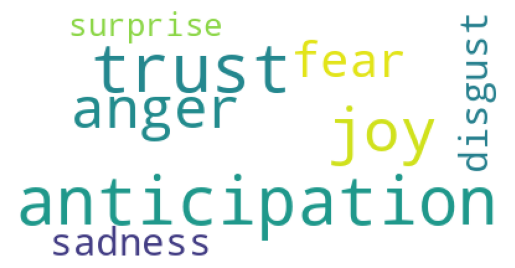

In [ ]:
wc = WordCloud(background_color="white").generate_from_frequencies(counts)
fig, ax = plt.subplots()
ax.imshow(wc)
ax.axis("off")

# Autocompletado

In [ ]:
word_range = LenRange(min_len=1, max_len=15)
sent_range = LenRange(min_len=3, max_len=10_000)
patterns = [
    re.compile(r"[^a-záéíóúñ ]"),
    re.compile(r"\s+")
]
preprocessor = Preprocessor(
    sw=[],
    word_range=word_range,
    sent_range=sent_range,
    patterns=patterns,
    language="spanish",
    unidecode=True
    )

In [ ]:
prep_text = preprocessor(text)

In [ ]:
df = (
    pd.DataFrame({
        "corpus": corpus
    })
    .assign(corpus_prep=lambda df: df.corpus.apply(preprocessor))
    .dropna()
)

In [ ]:
df

,corpus,corpus_prep
0,"\n\n\n\nDe Wikipedia, la enciclopedia libre\n\...",de wikipedia la enciclopedia libre noam chomsk...
1,; 1945-1949)Universidad de Pensilvania (M.A.,universidad de pensilvania m a
2,; 1949-1951)Universidad de Harvard (Lingüístic...,universidad de harvard linguistica alumno de z...
3,Es profesor emérito de lingüística en el Insti...,es profesor emerito de linguistica en el insti...
4,También es reconocido por su activismo polític...,tambien es reconocido por su activismo politic...
...,...,...
330,Enlaces externos[editar]\n Wikimedia Commons a...,enlaces externos editar wikimedia commons albe...
331,Wikiquote alberga frases célebres de o sobre N...,wikiquote alberga frases celebres de o sobre n...
332,Artículos de Noam Chomsky en The Guardian.,articulos de noam chomsky en the guardian
333,(en inglés)\nSitio web (en inglés).,en ingles sitio web en ingles


In [ ]:
vect = CountVectorizer(ngram_range=(3, 3)).fit(df.corpus_prep)
vocab = vect.get_feature_names_out()
counts = np.array(vect.transform(df.corpus_prep).sum(axis=0)).flatten()
vocab[np.random.randint(0, vocab.size, size=(100, ))]

array(['al parlamente europeo', 'de anos filadelfia', 'niveles de vida',
       'el acta que', 'con identificadores gndwikipedia',
       'tiempo el concepto', 'tarde los presentaria', 'new york vintage',
       'en el libre', 'benefactivo categorias gramaticales',
       'articulos principales principios', 'la izquierda en',
       'propios intereses profesionales', 'que el propio',
       'lo puede explicar', 'que su propia', 'catedra ferrari ward',
       'simplemente un ciudadano', 'efectuarse sobre algunos',
       'nelson goodman quien', 'ideas chocaban frontalmente',
       'jerarquia de chomsky', 'como chomsky tambien',
       'piraha descubrio presuntamente', 'param que indica',
       'de contexto principios', 'la ciencia la', 'percibe un cambio',
       'desarrollar algunas de', 'siguiente modulo hasta',
       'categorias gramaticales tales', 'ciencias humanas lo',
       'intelectuales firman un', 'de las leyes', 'religiosas hay una',
       'su doctorado en', 'predictivo 

In [ ]:
vocab

array(['aaaaj diccionarios enciclopedias', 'abarca la linguistica',
       'abril de es', ..., 'zellig harrisnelson goodmanroman',
       'zev chomsky estudioso', 'zev en la'], dtype=object)

In [ ]:
counts

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
counts_df = (
    pd.DataFrame(dict(vocab=vocab, counts=counts))
    .assign(
        prefix=lambda df: df.vocab.apply(lambda seq: " ".join(seq.split()[:-1])),
        suffix=lambda df: df.vocab.apply(lambda seq: seq.split()[-1])
    )
    .groupby("prefix", group_keys=True)
    .apply(
        lambda df: (
            df
            .assign(
                probs=df.counts / df.counts.sum(),
            )
            .filter(["prefix", "suffix", "probs"])
        )
    )
    .reset_index(drop=True)
)
counts_df

,prefix,suffix,probs
0,aaaaj diccionarios,enciclopedias,1.0
1,abarca la,linguistica,1.0
2,abril de,es,1.0
3,abstraccion conceptual,muy,1.0
4,abstractas que,permitiesen,1.0
...,...,...,...
5028,zellig harris,chomsky,0.5
5029,zellig harris,tambien,0.5
5030,zellig harrisnelson,goodmanroman,1.0
5031,zev chomsky,estudioso,1.0


In [ ]:
counts_df.query("probs < 1.0")

,prefix,suffix,probs
25,actividad cientifica,de,0.333333
26,actividad cientifica,no,0.333333
27,actividad cientifica,su,0.333333
29,activismo politico,arranca,0.200000
30,activismo politico,caracterizado,0.200000
...,...,...,...
5019,ya que,menudo,0.250000
5025,york times,estados,0.500000
5026,york times,lo,0.500000
5028,zellig harris,chomsky,0.500000


In [ ]:
text = "ya que"
(
    counts_df
    .query("prefix == @text")
    .sort_values(by="probs", ascending=False)
    .head(1)
    .suffix
    .iloc[0]
)

'atacaba'

In [ ]:
counts_df.query("prefix == @text")

,prefix,suffix,probs
5016,ya que,atacaba,0.25
5017,ya que,el,0.25
5018,ya que,exige,0.25
5019,ya que,menudo,0.25


- Probabilidad:

$$
P(t_1, t_2, \dots, t_m) = P(t_1)\prod_{i = 2}^mP(t_i|t_{i-1}, \dots, t_1)\\
P(t_1, t_2, t_3) = P(t_1)P(t_2 | t_1)P(t_3|t_2, t_1)
$$

- Markov: $t_{i+1}$ es independiente de cualquier termino $\{t_{i - 1}, t_{i - 2}, \dots\}$
$$
P(t_1, t_2, \dots, t_m) = \prod_{i = }^mP(t_i|t_{i-1}, \dots, t_1)\\
P(t_m|t_{m-1}, t_{m-2}, \dots) = P(t_{m-1})P(t_m | t_{m-1})
$$

**Autocompletado**

$$
\text{word} = \underset{t_m}{\text{argmax}} \left(P(t_m|t_{m-1}, t_{m-2}, \dots)\right)
$$

# Generacion de Texto

$$
t_m \sim P(t_m | t_{m - 1}, t_{m - 2}, \dots)
$$

In [ ]:
seed = "ya que"
n_words =
generated_text = seed.split()
for i in range(n_words):
    prefix = " ".join(generated_text[-2:])
    probs = counts_df.query("prefix == @prefix")
    word = np.random.choice(probs.suffix, p=probs.probs)
    generated_text.append(word)

In [ ]:
" ".join(generated_text)

'ya que atacaba los presupuestos centrales tanto del estructuralismo como de la poblacion mundial las condiciones son horrorosas menudo se deterioran lo'

# Entendimiento de Idiomas

In [1]:
%%shell
cp /content/drive/MyDrive/language.zip .
unzip language.zip

Archive:  language.zip
  inflating: Language Detection.csv  


In [6]:
sw = stopwords.words("spanish")
word_range = LenRange(min_len=3, max_len=15)
sent_range = LenRange(min_len=3, max_len=20)
patterns = [
    re.compile(r"[^a-z ]"),
    re.compile(r"\s+")
]
preprocessor = Preprocessor(
    sw=[],
    word_range=word_range,
    sent_range=sent_range,
    patterns=patterns,
    language="spanish"
    )

In [11]:
df = (
    pd.read_csv("Language Detection.csv")
    .assign(text=lambda df: df.Text.str.lower())
    .rename(columns={"Language": "language"})
    .filter(["text", "language"])
    .query("language in ['English', 'Spanish']")
)

In [12]:
df

,text,language
0,"nature, in the broadest sense, is the natural...",English
1,"""nature"" can refer to the phenomena of the phy...",English
2,"the study of nature is a large, if not the onl...",English
3,"although humans are part of nature, human acti...",English
4,[1] the word nature is borrowed from the old f...,English
...,...,...
5624,¿tiene ella?,Spanish
5625,supongo que no querría más pan de oro ahora ¿e...,Spanish
5626,"terry, en realidad te pareces un poco a ese án...",Spanish
5627,¿cómo pudiste ser él?,Spanish


In [23]:
vect = (
    TfidfVectorizer(ngram_range=(3, 3), analyzer="char")
    .fit(df.text)
)

In [24]:
counts_en = np.array(
    vect
    .transform(df.query("language == 'English'").text)
    .sum(axis=0)
).flatten()
counts_es = np.array(
    vect
    .transform(df.query("language == 'Spanish'").text)
    .sum(axis=0)
).flatten()
vocab = vect.get_feature_names_out()

In [25]:
counts_en = dict(zip(vocab, counts_en))
counts_es = dict(zip(vocab, counts_es))

[Text(0.5, 1.0, 'Spanish')]

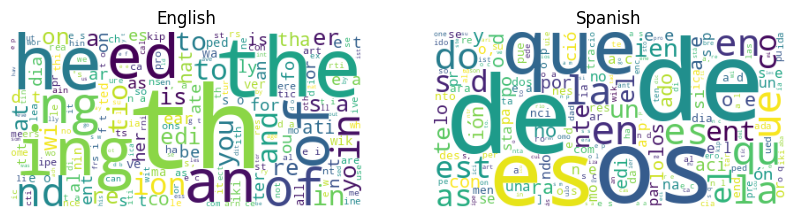

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
ax = axes[0]
wc = WordCloud(background_color="white").generate_from_frequencies(counts_en)
ax.imshow(wc)
ax.axis("off")
ax.set(title="English")

ax = axes[1]
wc = WordCloud(background_color="white").generate_from_frequencies(counts_es)
ax.imshow(wc)
ax.axis("off")
ax.set(title="Spanish")

# Big Data

In [27]:
%%shell
apt install openjdk-8-jdk-headless -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxtst6 amd64 2:1.2.3-1build4 [13.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-8-jre-headless amd64 8u382-ga-1~22.04.1 [30.8 MB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-8-jdk-headless amd64 8u382-ga-1~22.04.1 [8,851 kB]
Fetched

In [28]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [29]:
%%shell
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=f95fec82ba9ae53512ab526f724bc997d659afe6dcb57912e314e07b8fdf1e4a
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [57]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import Row
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF, HashingTF
from pyspark.ml import Pipeline

In [31]:
conf = (
    SparkConf()
    .setAppName("bow")
    .setMaster("local[4]")
)

In [32]:
sc = SparkContext(conf=conf)
spark = SparkSession(sparkContext=sc)

In [33]:
rdd = sc.parallelize(
    [
        "this is an example",
        "this is also an example and this is great",
        "the dog is running with the dog of the other man with no dog"
    ]
)

In [35]:
rdd.take(1)

['this is an example']

In [36]:
(
    rdd
    .map(lambda text: text.split())
    .map(lambda tokens: len(tokens))
    .collect()
)

[4, 9, 14]

In [38]:
ds = rdd.map(lambda text: Row(text=text))

In [39]:
df = spark.createDataFrame(data=ds)
df

DataFrame[text: string]

In [40]:
df.printSchema()

root
 |-- text: string (nullable = true)



In [44]:
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
tf = CountVectorizer(inputCol="tokens", outputCol="tf")
pipe = Pipeline(stages=[
    tokenizer, tf
])

In [46]:
model = pipe.fit(dataset=df)

In [47]:
bow = model.transform(dataset=df)
bow

DataFrame[text: string, tokens: array<string>, tf: vector]

In [48]:
bow.printSchema()

root
 |-- text: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tf: vector (nullable = true)



In [51]:
(
    bow
    .select(bow.tf)
    .toPandas()
)

,tf
0,"(1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
1,"(2.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
2,"(1.0, 3.0, 3.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, ..."


In [63]:
model.stages[1].vocabulary

['is',
 'dog',
 'the',
 'this',
 'an',
 'example',
 'with',
 'other',
 'running',
 'man',
 'no',
 'of',
 'great',
 'also',
 'and']

In [61]:
2 ** 3

8

In [69]:
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
tf = HashingTF(inputCol="tokens", outputCol="tf", numFeatures=16)
idf = IDF(inputCol="tf", outputCol="tfidf")
pipe = Pipeline(stages=[
    tokenizer, tf, idf
])

In [70]:
model = pipe.fit(dataset=df)

In [71]:
bow = model.transform(dataset=df)

In [73]:
(
    bow
    .select(bow.tfidf)
    .toPandas()
)

,tfidf
0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2876820724517..."
1,"(0.6931471805599453, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"(0.0, 2.772588722239781, 0.0, 0.0, 0.0, 0.0, 0..."
